# CREDIT CARD CUSTOMER SEGMENTATION 

## 02-22-2019
### Solution Proposed by Dieudonne

***Load libraries***

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import calinski_harabaz_score,silhouette_score
from sklearn.cluster import KMeans

***Read in the data, add and print missing values***

In [18]:
my_data =pd.read_csv("cc_info.csv")
missing = my_data.isna().sum()
print(missing)

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


***Imputation of missing values***

In [20]:
my_data = my_data.fillna( my_data.median() )

In [21]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8950 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

***Lets check the categories of cash advance, purchases transactions and tenures since the are integers***

In [5]:
my_data[['CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE']].nunique()

CASH_ADVANCE_TRX     65
PURCHASES_TRX       173
TENURE                7
dtype: int64

***Checking to see if there are relationships between varaibles in the dataset***

In [24]:
# let's remove CUST_ID  
my_data.drop("CUST_ID", axis=1, inplace=True)

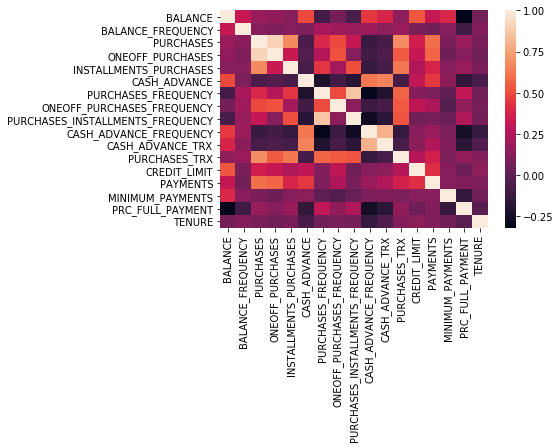

In [25]:
sns.heatmap(my_data.corr(),
            xticklabels=my_data.columns,
            yticklabels=my_data.columns)

***Purchase,ONEOFF_PURCHASE and Installments_purchases show strong correlations, lets explore them closer***

***Counts of zero ONEOFF_PURCHASES***

In [26]:
my_data[my_data['ONEOFF_PURCHASES']==0]['ONEOFF_PURCHASES'].count()

4302

***Counts of positive ONEOFF_PURCHASES***

In [37]:
my_data[(my_data['ONEOFF_PURCHASES']==0) & (my_data['INSTALLMENTS_PURCHASES']==0)].shape

(2042, 17)

***2042 Cases of no ONEOFF_PURCHASE and No INSTALLMENTS_PURCHASES***

In [28]:
my_data[my_data['ONEOFF_PURCHASES']>0]['ONEOFF_PURCHASES'].count()

4648

In [39]:
my_data[(my_data['ONEOFF_PURCHASES']==0) & (my_data['INSTALLMENTS_PURCHASES']>0)].shape

(2260, 17)

In [40]:
my_data[(my_data['ONEOFF_PURCHASES']>0) & (my_data['INSTALLMENTS_PURCHASES']==0)].shape

(1874, 17)

In [41]:
my_data[(my_data['ONEOFF_PURCHASES']>0) & (my_data['INSTALLMENTS_PURCHASES']>0)].shape

(2774, 17)

Lets right a function for those cases above 

In [44]:
def CustomerPurchase(data):
    
   
    if (data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']==0):
        return 'BOTH NULL'
    if (data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']>0):
         return 'ONEOFF PURCHASE & INSTALLMENTS PURCHASE'
    if (data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']==0):
        return 'ONLY ONEOFF PURCHASE'
    if (data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']>0):
        return 'ONLY INSTALLMENTS PURCHASE'

In [45]:
my_data['purchase_type']=my_data.apply(CustomerPurchase,axis=1)

In [46]:
my_data['purchase_type'].value_counts()

ONEOFF PURCHASE & INSTALLMENTS PURCHASE    2774
ONLY INSTALLMENTS PURCHASE                 2260
BOTH NULL                                  2042
ONLY ONEOFF PURCHASE                       1874
Name: purchase_type, dtype: int64

In [48]:
my_data['purchase_type'].value_counts().sum()

8950

***Monthly average purchases***

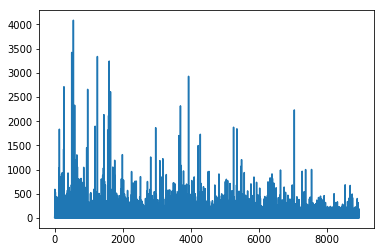

In [51]:
my_data['Monthly_avg_purchase']=my_data['PURCHASES']/my_data['TENURE']
my_data.Monthly_avg_purchase.plot()

***Average monthly cash advance***

In [66]:
my_data['Monthly_cash_advance']=my_data['CASH_ADVANCE']/my_data['TENURE']

***Balance versus credit limit***

In [55]:
my_data['Limit_usage']=my_data.apply(lambda x: x['BALANCE']/x['CREDIT_LIMIT'], axis=1)
my_data.Limit_usage.head()

0    0.040901
1    0.457495
2    0.332687
3    0.222223
4    0.681429
Name: Limit_usage, dtype: float64

***Payment versus minimum payment***

In [57]:
my_data['payment_minpayment']=my_data.apply(lambda x:x['PAYMENTS']/x['MINIMUM_PAYMENTS'],axis=1)

***Checking for outliers***

Text(0.5, 1.0, 'Boxplot by purchase types')

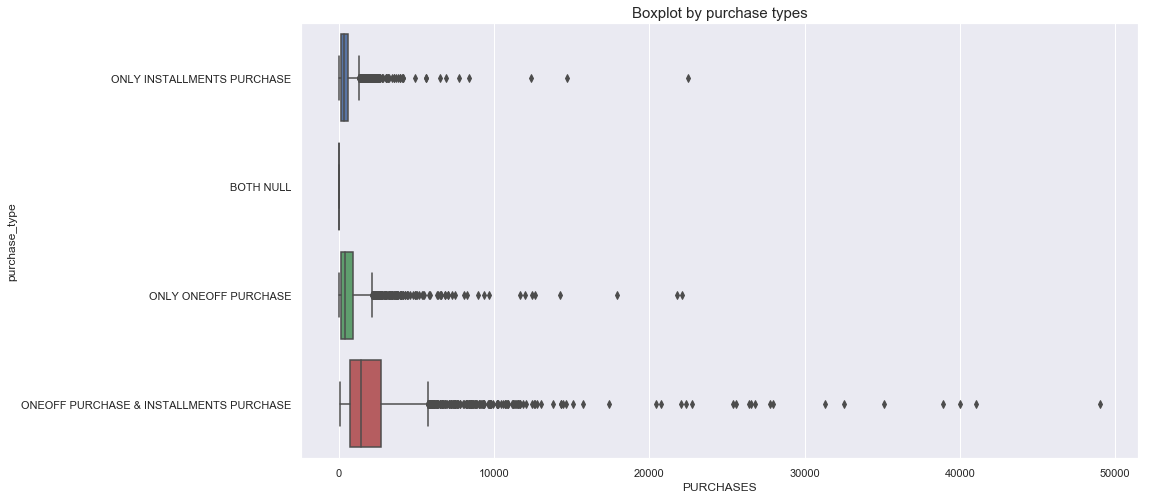

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.boxplot(my_data.PURCHASES.dropna(), my_data.purchase_type)
plt.title('Boxplot by purchase types', fontsize = 15)

***So many and a lot of extreme values, log transformation is necessary***

In [63]:
my_data_log=my_data.drop(['purchase_type'],axis=1).applymap(lambda x: np.log(x+1))

In [64]:
my_data_log.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Limit_usage,payment_minpayment
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,6.161637,0.619940,4.899647,3.204274,3.352403,3.319086,0.361268,0.158699,0.270072,0.113512,0.817570,1.894731,8.094825,6.624540,5.916079,0.117730,2.519680,3.050877,0.296081,1.357600
std,2.013303,0.148590,2.916872,3.246365,3.082973,3.566298,0.277317,0.216672,0.281852,0.156716,1.009316,1.373856,0.819629,1.591763,1.169929,0.211617,0.130367,2.002823,0.250303,0.940149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.931826,0.000000,0.018982,0.000000,1.945910,0.000000,0.000000,0.000000
25%,4.861995,0.635989,3.704627,0.000000,0.000000,0.000000,0.080042,0.000000,0.000000,0.000000,0.000000,0.693147,7.378384,5.951361,5.146667,0.000000,2.564949,1.481458,0.040656,0.648817
50%,6.773521,0.693147,5.892417,3.663562,4.499810,0.000000,0.405465,0.080042,0.154151,0.000000,0.000000,2.079442,8.006701,6.754489,5.747301,0.000000,2.564949,3.494587,0.264455,1.109459
75%,7.628099,0.693147,7.013133,6.360274,6.151961,7.016449,0.650588,0.262364,0.559616,0.200671,1.609438,2.890372,8.779711,7.550732,6.671670,0.133531,2.564949,4.587295,0.540911,1.953415
max,9.854515,0.693147,10.800403,10.615512,10.021315,10.760839,0.693147,0.693147,0.693147,0.916291,4.820282,5.883322,10.308986,10.834125,11.243832,0.693147,2.564949,8.315721,2.827902,8.830767


Text(0.5, 1.0, 'Average ration of payment/minimum payment with different types of purchase')

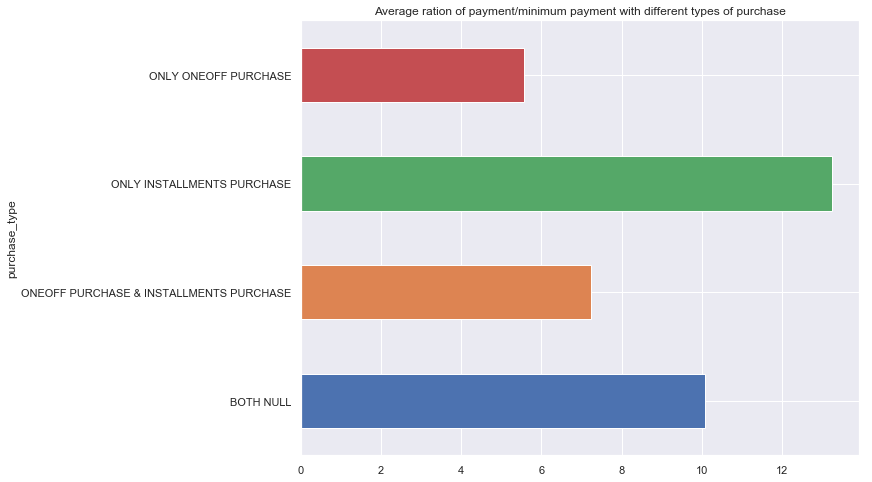

In [127]:
 #Average payment divided by payment payement  for each purchase type.
x=my_data.groupby('purchase_type').apply(lambda x: np.mean(x['payment_minpayment'])).plot.barh()
#type(x)
#x.values
plt.title('Average ration of payment/minimum payment with different types of purchase')


Text(0.5, 1.0, 'Average cash advance taken by customers with different type of purchase')

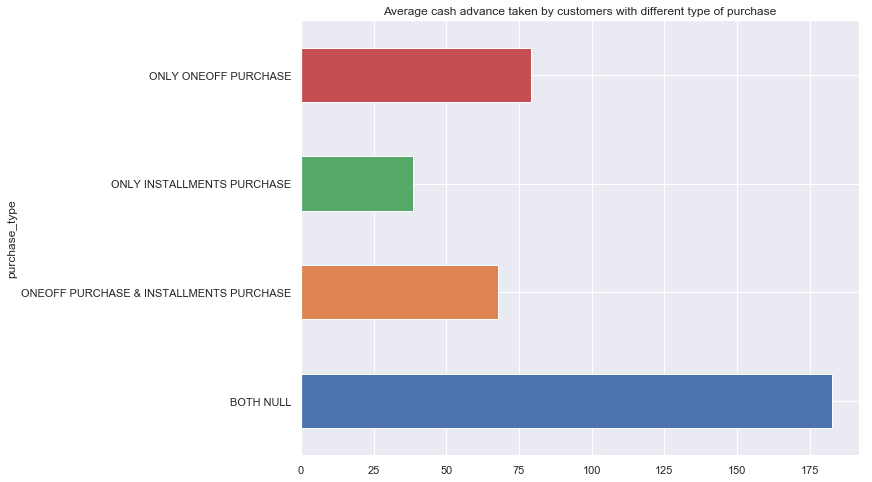

In [68]:
my_data.groupby('purchase_type').apply(lambda x: np.mean(x['Monthly_cash_advance'])).plot.barh()

plt.title('Average cash advance taken by customers with different types of purchase')

### CUSTOMERS WITH NO ONEOFF AND NO INSTALLMENTS PURCHASE TAKE HIGH CASH ADVANCE,
SO TARGETING THEM WITH INCENTIVES IN CASH ADVANCE RATE CARDS COULD HELP THEM SIGN UP MORE.

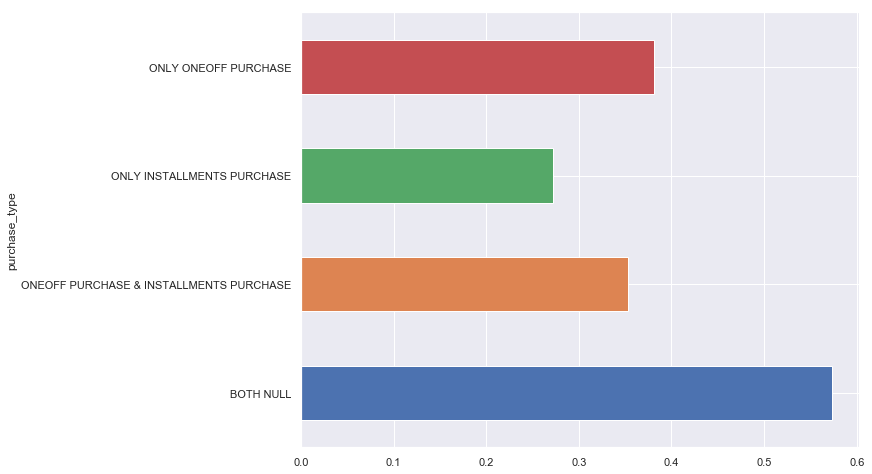

In [70]:
my_data.groupby('purchase_type').apply(lambda x: np.mean(x['Limit_usage'])).plot.barh()

### CUSTOMERS IN THIS CATEGORY WITH NO ONEOFF PURCHASE AND NO INSTALLMENTS tend to carry high limit usage: Risky
### Customers with installments purchases have good credit score as their limit is low

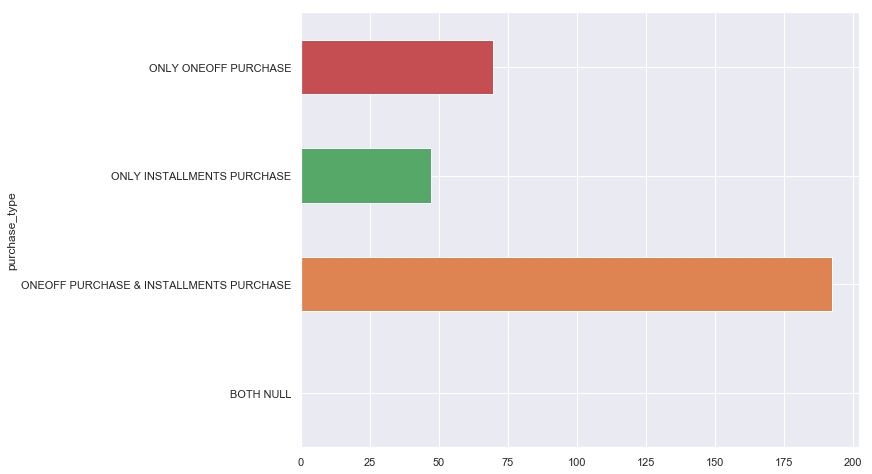

In [71]:
my_data.groupby('purchase_type').apply(lambda x: np.mean(x['Monthly_avg_purchase'])).plot.barh()

### This category spend well! cards with low interests in ONEOFF AND INSTALLMENTS PURCHASE WILL BE ATTRACTIVE TO THEM

In [86]:
col=['BALANCE','PURCHASES','CASH_ADVANCE','TENURE','PAYMENTS','MINIMUM_PAYMENTS','PRC_FULL_PAYMENT','CREDIT_LIMIT']
my_data_pre=my_data_log[[x for x in my_data_log.columns if x not in col ]]

In [87]:
# Original dataset with categorical column converted to number type.
my_data_original=pd.concat([my_data,pd.get_dummies(my_data['purchase_type'])],axis=1)


In [88]:
# creating Dummies for categorical variable
my_data_pre['purchase_type']=my_data.loc[:,'purchase_type']
pd.get_dummies(my_data_pre['purchase_type'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,BOTH NULL,ONEOFF PURCHASE & INSTALLMENTS PURCHASE,ONLY INSTALLMENTS PURCHASE,ONLY ONEOFF PURCHASE
0,0,0,1,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,0,0,1,0
6,0,1,0,0
7,0,0,1,0
8,0,1,0,0
9,0,0,0,1


In [78]:
my_data_dummy=pd.concat([my_data_pre,pd.get_dummies(my_data_pre['purchase_type'])],axis=1)

In [79]:
l=['purchase_type']

In [83]:
from sklearn.preprocessing import  StandardScaler

In [84]:
sc=StandardScaler()

In [98]:
my_data_dummy.drop("purchase_type",axis=1,inplace=True)

In [102]:
my_data_scaled=sc.fit_transform(my_data_dummy)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


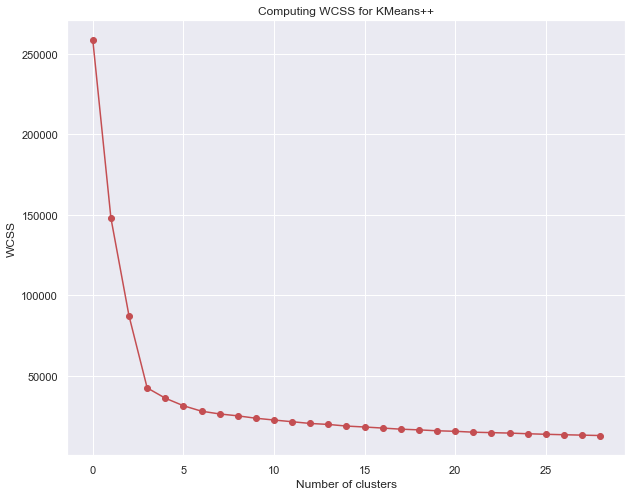

In [101]:
# Let's assume we use all cols except CustomerID
vals = my_data_dummy.iloc[ :, 1:].values
# Use the Elbow method to find a good number of clusters using WCSS
wcss = []
for ii in range( 1, 30 ):
    kmeans = KMeans(n_clusters=ii, init="k-means++", n_init=10, max_iter=300) 
    kmeans.fit_predict( vals )
    wcss.append( kmeans.inertia_ )
    
plt.plot( wcss, 'ro-', label="WCSS")
plt.title("Computing WCSS for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [103]:
from sklearn.metrics import calinski_harabaz_score,silhouette_score

In [104]:
score={}
score_c={}
for n in range(3,10):
    km_score=KMeans(n_clusters=n)
    km_score.fit(my_data_log)
    score_c[n]=calinski_harabaz_score(my_data_log,km_score.labels_)
    score[n]=silhouette_score(my_data_log,km_score.labels_)

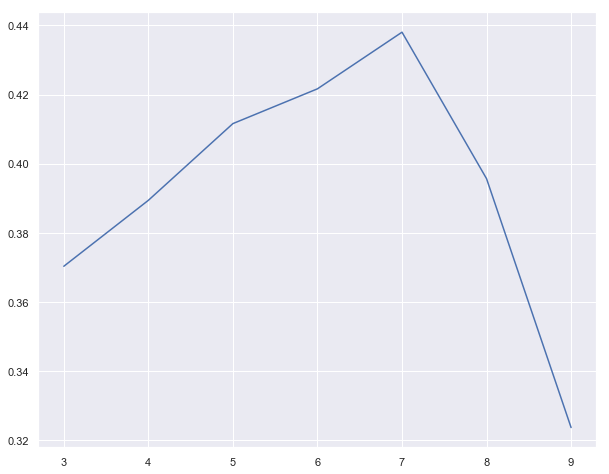

In [105]:
pd.Series(score).plot()

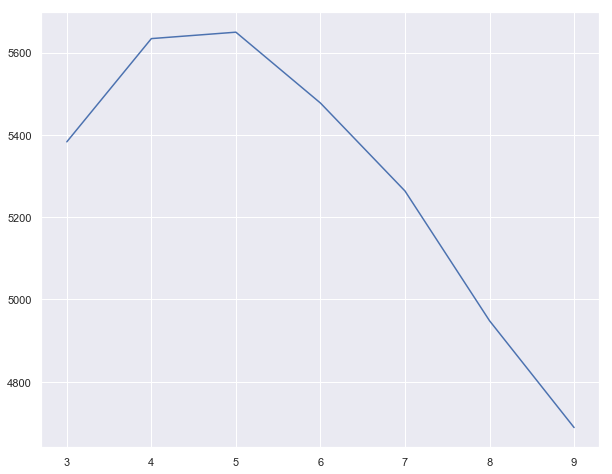

In [106]:
pd.Series(score_c).plot()

In [108]:
from sklearn.decomposition import PCA

In [110]:
var_ratio={}
for n in range(4,15):
    pc=PCA(n_components=n)
    my_data_pca=pc.fit(my_data_scaled)
    var_ratio[n]=sum(my_data_pca.explained_variance_ratio_)

In [111]:
p=pc.fit(my_data_scaled)

In [112]:
my_data_scaled.shape

(8950, 16)

In [113]:
p.explained_variance_

array([6.47967434, 2.91694896, 2.29202294, 1.36364236, 1.01115705,
       0.70380711, 0.38132069, 0.34862738, 0.20811415, 0.10598579,
       0.06190149, 0.0491323 , 0.04478678, 0.02847344])

In [114]:
var_ratio

{4: 0.8156768900788921,
 5: 0.8788671445189602,
 6: 0.922850173957836,
 7: 0.9466800542480797,
 8: 0.9684668311253375,
 9: 0.9814725120333742,
 10: 0.9880958838252278,
 11: 0.9919642946026703,
 12: 0.9950347203573552,
 13: 0.9978335815134605,
 14: 0.9996129729851255}

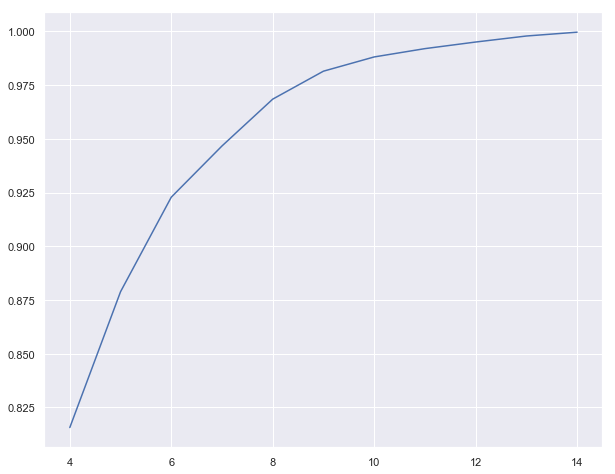

In [115]:
pd.Series(var_ratio).plot()

In [117]:
pc_final=PCA(n_components=5).fit(my_data_scaled)

reduced_cr=pc_final.fit_transform(my_data_scaled)

In [118]:
col_list=my_data_dummy.columns

In [119]:
pd.DataFrame(pc_final.components_.T, columns=['PC_' +str(i) for i in range(5)],index=col_list)

,PC_0,PC_1,PC_2,PC_3,PC_4
BALANCE_FREQUENCY,0.045477,0.172647,-0.384067,-0.278813,-0.191793
ONEOFF_PURCHASES,0.231277,0.446595,0.122718,0.003057,-0.030936
INSTALLMENTS_PURCHASES,0.325613,-0.212678,-0.233449,0.091477,0.011619
PURCHASES_FREQUENCY,0.360793,-0.060465,-0.119178,-0.092439,0.096952
ONEOFF_PURCHASES_FREQUENCY,0.231992,0.382749,0.061696,0.045807,-0.039717
PURCHASES_INSTALLMENTS_FREQUENCY,0.308313,-0.228161,-0.246966,0.024307,0.032845
CASH_ADVANCE_FREQUENCY,-0.191411,0.206133,-0.369816,0.093449,0.512458
CASH_ADVANCE_TRX,-0.204846,0.208111,-0.373974,0.100628,0.467413
PURCHASES_TRX,0.373309,0.044076,-0.089023,-0.070076,0.089840
Monthly_avg_purchase,0.361903,0.112853,0.028570,-0.115182,0.161494


In [120]:
# Factor Analysis : variance explained by each component- 
pd.Series(pc_final.explained_variance_ratio_,index=['PC_'+ str(i) for i in range(5)])

PC_0    0.404934
PC_1    0.182289
PC_2    0.143235
PC_3    0.085218
PC_4    0.063190
dtype: float64

In [121]:
km=KMeans(n_clusters=4,random_state=42)

In [123]:
km.fit(reduced_cr)
km.labels_

array([2, 3, 1, ..., 2, 3, 1], dtype=int32)

In [124]:
pd.Series(km.labels_).value_counts()

0    2760
2    2239
3    2071
1    1880
dtype: int64

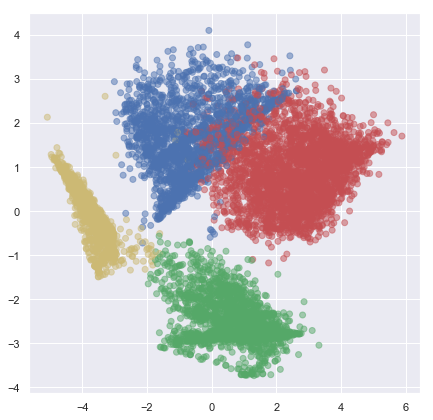

In [125]:
color_map={0:'r',1:'b',2:'g',3:'y'}
label_color=[color_map[l] for l in km.labels_]
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0],reduced_cr[:,1],c=label_color,cmap='Spectral',alpha=0.5)

### CONCLUSION

***First segment***
They are potential target customers who are paying dues and making 
purchases and maintaining comparatively good credit score ) credit limit could be inscreased  or lower interest rate -- Can be given premium cards  to increase transactions 

***Second segment***
They have a poor credit score and taking only cash on advance. We can target them by providing less interest rate on a purchase transaction 

***Third segment***
 This group has a minimum paying ratio and using the card for just one-off transactions. This group seems to be a risk group. 
 
***fourth segment***
This group is performing best among all as customers are maintaining a good credit score and paying dues on time. Rewards point could make them purchase more.